In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.processor.ljspeech import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import symbols, _symbol_to_id

from tensorflow_tts.configs import Tacotron2Config
from tensorflow_tts.models import TFTacotron2

import IPython.display as ipd

In [2]:
with open('./config.yml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

In [3]:
config = Tacotron2Config(**config["tacotron2_params"])

In [4]:
config.prenet_dropout_rate = 0.5

In [5]:
tacotron2 = TFTacotron2(config=config, training=False, name="tacotron2")

In [6]:
tacotron2._build()

In [7]:
tacotron2.summary()

Model: "tacotron2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (TFTacotronEncoder)  multiple                  8218624   
_________________________________________________________________
decoder_cell (TFTacotronDeco multiple                  18246402  
_________________________________________________________________
post_net (TFTacotronPostnet) multiple                  5460480   
_________________________________________________________________
residual_projection (Dense)  multiple                  41040     
Total params: 31,966,546
Trainable params: 31,956,306
Non-trainable params: 10,240
_________________________________________________________________


In [8]:
tacotron2.load_weights("./pretrained/model-55000.h5")

In [9]:
input_text = "In a statement announcing his resignation, Mr Ross, said: \
While the intentions may have been well meaning, the reaction to this news \
shows that Mr Cummings interpretation of the government advice was not shared \
by the vast majority of people who have done as the government asked."

In [10]:
input_ids = LJSpeechProcessor(None, None).text_to_sequence(input_text.lower(), ["english_cleaners"])
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)

In [11]:
# @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.int32),
#                               tf.TensorSpec(shape=[None], dtype=tf.int32)])
# def inference(input_ids, input_lengths):
#     decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
#         input_ids=input_ids,
#         input_lengths=input_lengths,
#         speaker_ids=tf.convert_to_tensor(np.array([0]), dtype=tf.int32),
#         use_window_mask=False,
#         win_front=4,
#         win_back=6
#     )
#     return decoder_output, mel_outputs, stop_token_prediction, alignment_history

In [12]:
# import time
# start = time.time()
# decoder_output, mel_outputs, stop_token_prediction, alignment_history = inference(
#     input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
#     input_lengths=tf.convert_to_tensor(np.array([len(input_ids)]), dtype=tf.int32))
# print(time.time() - start)

In [27]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        input_ids=np.expand_dims(input_ids, 0),
        input_lengths=np.array([len(input_ids)]),
        speaker_ids=tf.convert_to_tensor(np.array([0]), dtype=tf.int32),
        use_window_mask=True,
        win_front=6,
        win_back=6
)

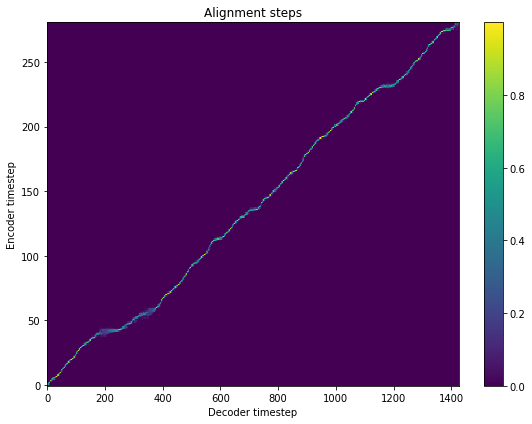

In [28]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

In [29]:
alignment_history.numpy().shape

(1, 281, 1426)

In [30]:
def get_durations_from_alignments(alignment):
    D = np.array([0 for _ in range(np.shape(alignment)[0])])
    
    for i in range(np.shape(alignment)[1]):
        max_index = alignment[:, i].tolist().index(alignment[:, i].max())
        D[max_index] = D[max_index] + 1
        
    return D

In [31]:
D = get_durations_from_alignments(alignment_history.numpy()[0])

In [32]:
D

array([ 1,  5,  3,  2,  5,  5,  8,  6,  7,  3,  3,  2,  3,  5,  3,  3,  3,
        5,  5,  4,  6,  5,  4,  3,  2,  3,  3,  5,  2,  5,  3,  7,  5,  9,
        4,  4,  6,  8,  2, 10, 14,  7, 24, 35,  7,  5,  3, 10, 10,  2,  2,
        7, 10,  4, 14, 11, 10,  0, 19,  5,  5,  7,  3,  2,  1,  1,  3,  4,
        4,  4,  7,  7,  6,  4,  2,  4,  8,  5,  6,  3,  3,  4,  3,  3,  2,
        4,  3,  1,  5,  2,  2,  4,  3,  5,  6,  9,  3,  4,  5,  5,  5,  6,
        3,  5,  1,  4,  0,  1,  2,  1,  5,  3, 11, 16,  7,  6,  2,  5,  4,
        5,  5,  3,  3,  2,  3,  5,  4,  7,  3,  4, 13,  2,  7,  4,  2, 16,
       18,  2,  6,  2,  1,  3,  3,  3,  8,  9,  2,  6,  5,  0,  6,  5,  5,
        6,  2,  3,  5,  4,  5,  3,  5,  3,  4,  4,  8,  9,  7,  1,  5,  4,
        3,  3,  2,  2,  3,  0,  1,  4,  5,  5,  4,  2,  4,  4,  4,  2,  3,
        5,  3,  6,  3,  7, 12,  6,  3,  6,  3,  3,  4,  5,  7,  7,  6,  4,
        4,  8,  6,  6,  3,  4,  3,  5,  5,  3,  2,  2,  1,  4,  7, 17,  4,
        7,  2,  4,  6,  6

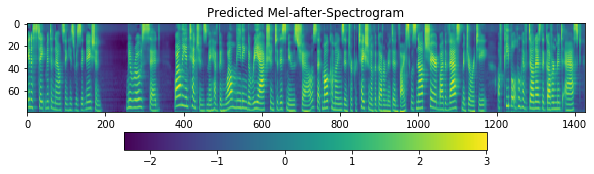

In [33]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

MELGAN VOCODER

In [34]:
from tensorflow_tts.models import TFMelGANGenerator
from tensorflow_tts.configs import MelGANGeneratorConfig

In [35]:
config = MelGANGeneratorConfig(is_weight_norm=False)
melgan = TFMelGANGenerator(config=config, name='melgan_generator')
melgan(np.expand_dims(mel_outputs, 0))  # build model.

<tf.Tensor: shape=(1, 365056, 1), dtype=float32, numpy=
array([[[ 9.0808952e-14],
        [-3.9231822e-14],
        [-8.7555051e-14],
        ...,
        [ 1.8773770e-14],
        [ 3.4141018e-14],
        [ 2.8723802e-14]]], dtype=float32)>

In [36]:
melgan.load_weights('./pretrained/generator-2080000.h5')

In [37]:
melgan = tf.function(melgan, 
                     experimental_relax_shapes=True, 
                     input_signature=[tf.TensorSpec(shape=[None, None, 80], dtype=tf.float32)])

In [38]:
audio_pred = melgan(np.expand_dims(mel_outputs, 0))[0, :, 0].numpy()

In [39]:
ipd.Audio(audio_pred, rate=22050)

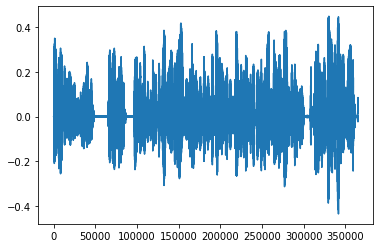

In [40]:
plt.plot(audio_pred)